# toad使用教程

toad是针对工业届建模而开发的工具包，针对风险评分卡的建模有针对性的功能。toad持续更新优化中，本教程针对toad的各类主要功能进行介绍，包括：
1. EDA相关功能
2. 如何使用toad高效分箱并进行特征筛选
3. WOE转化
4. 逐步回归特征筛选
5. 模型检验和评判
6. 标准评分卡转化和输出
7. 其他功能

-----------------
-----------------

### 
本教程将使用高维的数据来演示如何使用toad高效建模

***安装与升级：***
1. pip安装：!pip install toad
2. conda安装：conda install toad --channel conda-forge
3. 升级：!pip install -U toad; conda install -U toad --channel conda-forge

***有使用问题欢迎到[github](https://github.com/amphibian-dev/toad)上提issue***

In [1]:
import pandas as pd
import numpy as np
import toad

In [1]:
'''
请升级到最新版本
'''

'\n请升级到最新版本\n'

-----------------------
### <font color='blue'>### 0. 读取数据</font>

演示数据为165维，包括一列主键，target列，和month列。其中包含了若干个离散型变量和连续性变量，且有一定的缺失值。

***本教程将展示遇到这类很“脏”的数据时，如何使用toad进行有效且高效的建模。***

In [3]:
data = pd.read_csv('train.csv')
print('Shape:',data.shape)
data.head(10)

Shape: (108940, 167)


,APP_ID_C,target,var_d1,var_d2,var_d3,var_d4,var_d5,var_d6,var_d7,var_d8,...,var_l_118,var_l_119,var_l_120,var_l_121,var_l_122,var_l_123,var_l_124,var_l_125,var_l_126,month
0,app_1,0,Hit-6+ Vintage,816.0,RESIDENT INDIAN,Post-Graduate,M,RESIDENT INDIAN,SELF-EMPLOYED,Y,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
1,app_2,0,NaN,841.0,RESIDENT INDIAN,Post-Graduate,F,RESIDENT INDIAN,SALARIED,N,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
2,app_3,0,Hit-6+ Vintage,791.0,RESIDENT INDIAN,Post-Graduate,M,RESIDENT INDIAN,PROPRIETOR,Y,...,0.0,0.088235,0.0,0.100000,0.0,0.011494,0.5,0.000000,0.0,2019-03
3,app_4,0,Hit-6+ Vintage,821.0,RESIDENT INDIAN,Graduate,M,RESIDENT INDIAN,SELF-EMPLOYED,N,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
4,app_5,0,Hit-6+ Vintage,807.0,RESIDENT INDIAN,Graduate,M,RESIDENT INDIAN,SALARIED,Y,...,0.0,0.000000,0.0,0.000000,0.0,0.540541,0.0,0.285714,0.0,2019-03
5,app_6,0,Hit-6+ Vintage,788.0,RESIDENT INDIAN,Others,M,RESIDENT INDIAN,SALARIED,N,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
6,app_7,0,Hit-6+ Vintage,779.0,RESIDENT INDIAN,Graduate,M,RESIDENT INDIAN,ATTORNEY AT LAW,Y,...,0.0,0.722222,0.0,0.777778,0.0,0.380952,0.0,0.571429,0.0,2019-03
7,app_8,0,Hit-6+ Vintage,801.0,RESIDENT INDIAN,Post-Graduate,M,RESIDENT INDIAN,SAL(RETIRAL AGE 60),N,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
8,app_9,0,Hit-6+ Vintage,815.0,RESIDENT INDIAN,Graduate,F,RESIDENT INDIAN,NaN,Y,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03
9,app_10,0,NaN,804.0,RESIDENT INDIAN,Graduate,M,RESIDENT INDIAN,PROPRIETOR,N,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,2019-03


#### 数据包含2019年5月 - 7月的数据。其中我们将用3月和4月数据用于训练样本，5月、6月、7月数据作为时间外样本（OOT）。

In [4]:
print('month:',data.month.unique())

month: ['2019-03' '2019-04' '2019-05' '2019-06' '2019-07']


In [5]:
train = data.loc[data.month.isin(['2019-03','2019-04'])==True,:]
OOT = data.loc[data.month.isin(['2019-03','2019-04'])==False,:]

#train = data.loc[data.month.isin(['Mar-19','Apr-19'])==True,:]
#OOT = data.loc[data.month.isin(['Mar-19','Apr-19'])==False,:]
print('train size:',train.shape,'\nOOT size:',OOT.shape)

train size: (43576, 167) 
OOT size: (65364, 167)


-----------------------
### <font color='blue'>### I. EDA相关功能</font>

#### 1. toad.detect(dataframe): 

用于检测数据情况（EDA）。输出每列特征的统计性特征和其他信息，主要的信息包括：缺失值、unique values、数值变量的平均值、离散值变量的众数等。如下面的cell，可以得到以下信息：

a. 正样本占比2.2%：target的mean是0.0219479

b. 部分特征有缺失值，且缺失值不等：注意missing列。

c. 数值型变量和离散型变量有若干个，部分离散型变量的unique values较多，有10多个甚至84个：离散型变量的unique列。

In [6]:
toad.detect(train)[:10]

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
APP_ID_C,object,43576,0.00%,43576,app_36227:0.00%,app_29819:0.00%,app_35476:0.00%,app_10104:0.00%,app_35794:0.00%,app_25789:0.00%,app_36858:0.00%,app_12750:0.00%,app_24:0.00%,app_13004:0.00%
target,int64,43576,0.00%,2,0.0213191,0.144447,0,0,0,0,0,0,1,1
var_d1,object,43576,37.57%,2,Hit-6+ Vintage:60.32%,Hit-lt 6 Vinta:2.10%,None,None,None,None,None,None,Hit-6+ Vintage:60.32%,Hit-lt 6 Vinta:2.10%
var_d2,float64,43576,5.44%,389,570.492,355.565,-1,-1,-1,778,810,832,864,900
var_d3,object,43576,5.31%,6,RESIDENT INDIAN:94.00%,NON-RESIDENT INDIAN:0.64%,PARTNERSHIP FIRM:0.02%,PRIVATE LTD COMPANIES:0.02%,PUBLIC LTD COMPANIES:0.00%,NON-RESIDENT INDIAN:0.64%,PARTNERSHIP FIRM:0.02%,PRIVATE LTD COMPANIES:0.02%,PUBLIC LTD COMPANIES:0.00%,OVERSEAS CITIZEN OF INDIA:0.00%
var_d4,object,43576,1.08%,5,Graduate:55.30%,Post-Graduate:21.57%,Others:10.71%,Under Graduate:10.67%,Professional:0.67%,Graduate:55.30%,Post-Graduate:21.57%,Others:10.71%,Under Graduate:10.67%,Professional:0.67%
var_d5,object,43576,1.08%,3,M:79.70%,F:14.33%,O:4.89%,None,None,None,None,M:79.70%,F:14.33%,O:4.89%
var_d6,object,43576,1.08%,13,RESIDENT INDIAN:93.34%,PRIVATE LTD COMPANIES:2.57%,PARTNERSHIP FIRM:1.45%,PUBLIC LTD COMPANIES:0.73%,NON-RESIDENT INDIAN:0.64%,CO-OPERATIVE SOCIETIES:0.01%,LIMITED LIABILITY PARTNERSHIP:0.00%,ASSOCIATION:0.00%,TRUST-NGO:0.00%,OVERSEAS CITIZEN OF INDIA:0.00%
var_d7,object,43576,1.60%,84,SALARIED:31.43%,PROPRIETOR:31.31%,SELF-EMPLOYED:10.74%,OTHERS:6.40%,FIRST TIME USERS:2.72%,NURSE:0.00%,PHARMACIST:0.00%,RETAIL BUS OPERATOR:0.00%,PRIVATE TAILOR:0.00%,TAXI DRIVER:0.00%
var_d8,object,43576,1.08%,2,Y:59.90%,N:39.03%,None,None,None,None,None,None,Y:59.90%,N:39.03%


#### 2. toad.quality(dataframe, target='target', iv_only=False):


输出每个变量的iv值，gini，entropy，和unique values，结果以iv值排序。"target"为目标列，"iv_only"决定是否只输出iv值。

<font color='red'>注意：1. 对于数据量大或高维度数据，建议使用iv_only=True 2. 要去掉主键，日期等高unique values且不用于建模的特征</font>

In [7]:
to_drop = ['APP_ID_C','month'] # 去掉ID列和month列
toad.quality(data.drop(to_drop,axis=1),'target',iv_only=True)[:15]

,iv,gini,entropy,unique
var_b19,0.353043,NaN,NaN,88.0
var_b18,0.317603,NaN,NaN,46.0
var_d2,0.313443,NaN,NaN,411.0
var_d7,0.309985,NaN,NaN,95.0
var_b10,0.301111,NaN,NaN,15726.0
var_b17,0.240104,NaN,NaN,235.0
var_b16,0.231403,NaN,NaN,104.0
var_b24,0.226939,NaN,NaN,30928.0
var_b20,0.198655,NaN,NaN,34.0
var_b11,0.187306,NaN,NaN,239.0


-----------------------
### <font color='blue'>### II. 如何使用toad高效分箱并进行特征筛选</font>

#### 3. toad.selection.select(dataframe, target='target', empty=0.9, iv=0.02, corr=0.7, return_drop=False, exclude=None):

根据缺失值占比，iv值，和高相关性进行变量筛选，赋值为：

（1）empyt=0.9: 若变量的缺失值大于0.9被删除

（2）iv=0.02: 若变量的iv值小于0.02被删除

（3）corr=0.7: 若两个相关性高于0.7时，iv值低的变量被删除

（4）return_drop=False: 若为True，function将返回被删去的变量列

（5）exclude=None: 明确不被删去的列名，输入为list格式

如下面的cell，没有变量由于缺失值高被删除，大量变量因为低iv值被删除，部分相关性高的变量被删除。从165个特征中选出了32个变量。

In [8]:
train_selected, dropped = toad.selection.select(train,target = 'target', empty = 0.5, iv = 0.05, corr = 0.7, return_drop=True, exclude=['APP_ID_C','month'])
print(dropped)
print(train_selected.shape)

{'empty': array([], dtype=float64), 'iv': array(['var_d1', 'var_d4', 'var_d8', 'var_d9', 'var_b5', 'var_b6',
       'var_b7', 'var_l_1', 'var_l_2', 'var_l_3', 'var_l_4', 'var_l_5',
       'var_l_6', 'var_l_7', 'var_l_8', 'var_l_10', 'var_l_12',
       'var_l_14', 'var_l_15', 'var_l_16', 'var_l_17', 'var_l_18',
       'var_l_21', 'var_l_23', 'var_l_24', 'var_l_25', 'var_l_26',
       'var_l_27', 'var_l_28', 'var_l_29', 'var_l_30', 'var_l_31',
       'var_l_32', 'var_l_33', 'var_l_34', 'var_l_35', 'var_l_37',
       'var_l_38', 'var_l_39', 'var_l_40', 'var_l_41', 'var_l_42',
       'var_l_43', 'var_l_44', 'var_l_45', 'var_l_47', 'var_l_49',
       'var_l_51', 'var_l_53', 'var_l_55', 'var_l_56', 'var_l_57',
       'var_l_59', 'var_l_61', 'var_l_62', 'var_l_63', 'var_l_65',
       'var_l_67', 'var_l_70', 'var_l_72', 'var_l_75', 'var_l_76',
       'var_l_77', 'var_l_78', 'var_l_79', 'var_l_80', 'var_l_81',
       'var_l_82', 'var_l_83', 'var_l_84', 'var_l_85', 'var_l_86',
       'var_l_87',

#### 4. 分箱

toad的分箱功能支持数值型数据和离散型分箱，默认分箱方法使用 [卡方分箱](reference.html#chimerge)。

`toad.transform.Combiner` 是用来分箱的class，分箱步骤如下：

(1)  *** initalise: ***c = toad.transform.Combiner()

(2) ***训练分箱***: c.fit(dataframe, y = 'target', method = 'chi', min_samples = None, n_bins = None, empty_separate = False) 

    - y: 目标列

    - method: 分箱方法，支持'chi' (卡方分箱), 'dt' (决策树分箱), 'kmean' , 'quantile' (等频分箱), 'step' (等步长分箱)

    - min_samples: 每箱至少包含样本量，可以是数字或者占比
    
    - n_bins: 箱数，若无法分出这么多箱数，则会分出最多的箱数

    - empty_separate: 是否将空箱单独分开

(3) ***查看分箱节点***：c.export()

(4) ***手动调整分箱***: c.load(dict)

(5) ***apply分箱结果***: c.transform(dataframe, labels=False):

    - labels: 是否将分箱结果转化成箱标签。False时输出0,1,2...（离散变量根据占比高低排序），True输出(-inf, 0], (0,10], (10, inf)。

<font color='red'>注意：1. 注意删去不需要分箱的列，特别是ID列和时间列</font>

In [9]:
# initialise
c = toad.transform.Combiner()

# 使用特征筛选后的数据进行训练：使用稳定的卡方分箱，规定每箱至少有5%数据, 空值将自动被归到最佳箱。
c.fit(train_selected.drop(to_drop, axis=1), y = 'target', method = 'chi', min_samples = 0.05) #empty_separate = False

# 为了演示，仅展示部分分箱
print('var_d2:',c.export()['var_d2'])
print('var_d5:',c.export()['var_d5'])
print('var_d6:',c.export()['var_d6'])

var_d2: [747.0, 782.0, 820.0]
var_d5: [['O', 'nan', 'F'], ['M']]
var_d6: [['PUBLIC LTD COMPANIES', 'NON-RESIDENT INDIAN', 'PRIVATE LTD COMPANIES', 'PARTNERSHIP FIRM', 'nan'], ['RESIDENT INDIAN', 'TRUST', 'TRUST-CLUBS/ASSN/SOC/SEC-25 CO.', 'HINDU UNDIVIDED FAMILY', 'CO-OPERATIVE SOCIETIES', 'LIMITED LIABILITY PARTNERSHIP', 'ASSOCIATION', 'OVERSEAS CITIZEN OF INDIA', 'TRUST-NGO']]


#### 5. 观察分箱并调整

toad.plot的module提供了一部分的可视化功能，帮助调整分箱节点。

(1) ***时间内观察***： toad.plot.bin_plot(dataframe, x = None, target = 'target)

bar代表了样本量占比，红线代表了正样本占比（e.g. 坏账率）

    - x: 需要观察的特征
    
    - target: 目标列

In [10]:
from toad.plot import bin_plot

# 看'var_d2'在时间内的分箱
col = 'var_d2'

bin_plot(c.transform(train_selected[[col,'target']], labels=True), x=col, target='target')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(2) ***跨时间观察：*** toad.plot.badrate_plot(dataframe, target = 'target', x = None, by = None)

输出不同时间段中每箱的正样本占比

    - target: 目标列
    
    - x: 时间列, string格式
    
    - by: 需要观察的特征

<font color='red'>注意：时间列需要预先分好并设成string，不支持timestampe</font>

'\n敞口随时间变化而增大为优，代表了变量在更新的时间区分度更强。线之前没有交叉为优，代表分箱稳定。\n'

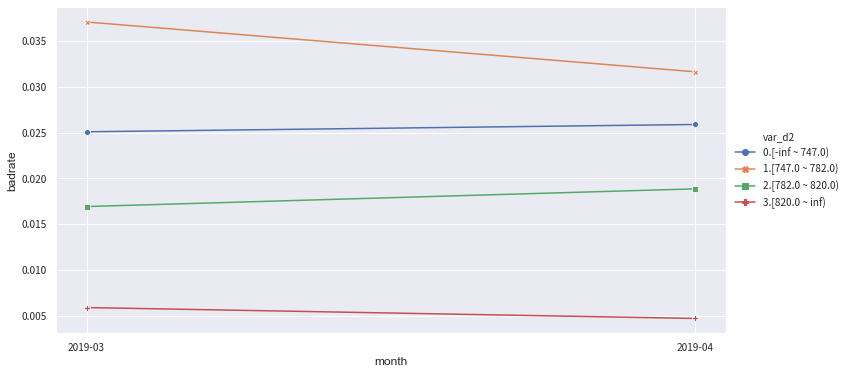

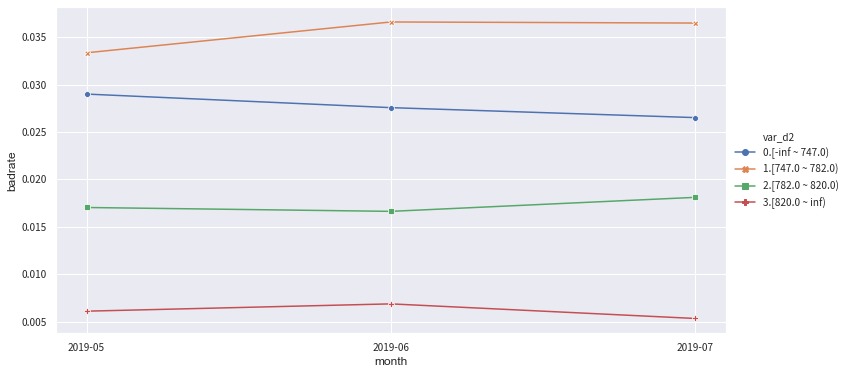

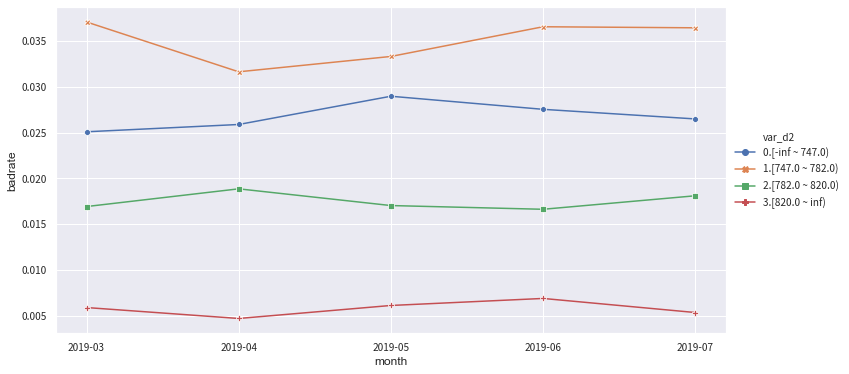

In [11]:
from toad.plot import badrate_plot

col = 'var_d2'

# 观察 'var_d2' 分别在时间内和OOT中的稳定性
badrate_plot(c.transform(train[[col,'target','month']], labels=True), target='target', x='month', by=col)
badrate_plot(c.transform(OOT[[col,'target','month']], labels=True), target='target', x='month', by=col)

badrate_plot(c.transform(data[[col,'target','month']], labels=True), target='target', x='month', by=col)
'''
敞口随时间变化而增大为优，代表了变量在更新的时间区分度更强。线之前没有交叉为优，代表分箱稳定。
'''

No handles with labels found to put in legend.
No handles with labels found to put in legend.


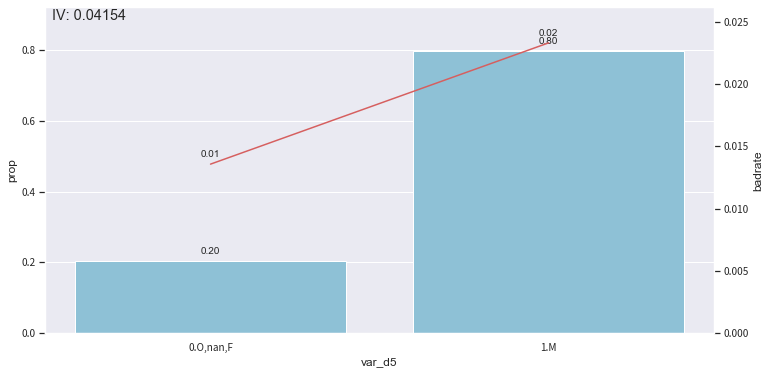

In [12]:
# 看'var_d5'在时间内的分箱
col = 'var_d5'

#观察单个变量分箱结果时，建议设置'labels = True'
bin_plot(c.transform(train_selected[[col,'target']], labels=True), x=col, target='target')

(3) ***调整分箱：***c.set_rules(dict)

set_rules 后会更新被修改的箱

No handles with labels found to put in legend.
No handles with labels found to put in legend.


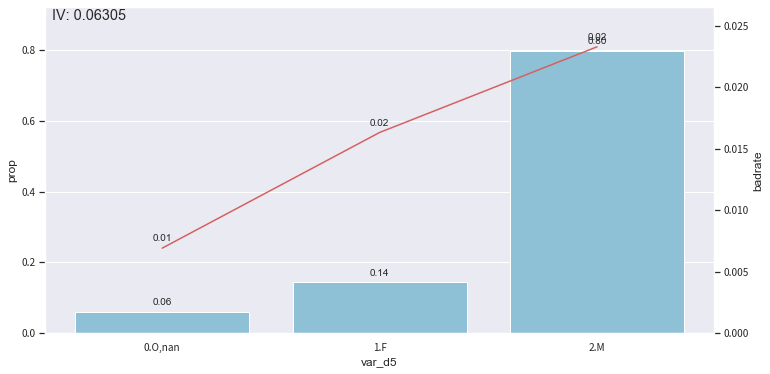

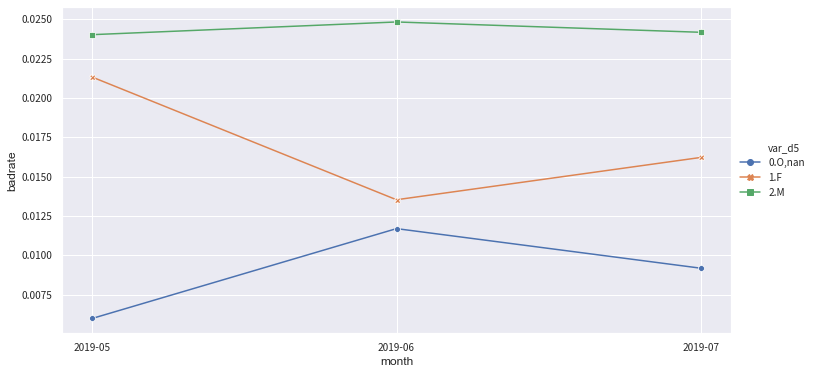

In [13]:
# iv值较低，假设我们要 'F' 淡出分出一组来提高iv

#设置分组
rule = {'var_d5':[['O', 'nan'],['F'], ['M']]}

#调整分箱
c.set_rules(rule)

#查看手动分箱稳定性
bin_plot(c.transform(train_selected[['var_d5','target']], labels=True), x='var_d5', target='target')
badrate_plot(c.transform(OOT[['var_d5','target','month']], labels=True), target='target', x='month', by='var_d5')

### <font color='blue'>###  III. WOE转化</font>

WOE转化在分箱调整好之后进行，步骤如下：

(1) ***用调整好的Combiner转化数据:*** c.transform(dataframe, labels=False)

    只会转化被分箱的变量

(2) ***初始化woe transer:*** transer =  toad.transform.WOETransformer()

(3) ***fit_transform:*** transer.fit_transform(dataframe, target, exclude = None)


    训练并输出woe转化的数据，用于转化train/时间内数据
    
    - target：目标列数据（非列名）
    
    - exclude: 不需要被WOE转化的列
<font color='red'> 注意：会转化所有列，包括未被分箱transform的列，通过 'exclude' 删去不要WOE转化的列，特别是target列</font>
    
(4)  ***根据训练好的transer，转化test/OOT数据：***transer.transform(dataframe)

根据训练好的transer输出woe转化的数据，用于转化test/OOT数据。

In [14]:
# 初始化
transer = toad.transform.WOETransformer()

# combiner.transform() & transer.fit_transform() 转化训练数据，并去掉target列
train_woe = transer.fit_transform(c.transform(train_selected), train_selected['target'], exclude=to_drop+['target'])
OOT_woe = transer.transform(c.transform(OOT))

print(train_woe.head(3))

  APP_ID_C  target    var_d2    var_d3    var_d5    var_d6    var_d7  \
0    app_1       0 -0.178286  0.046126  0.090613  0.047145  0.365305   
1    app_2       0 -1.410248  0.046126 -0.271655  0.047145 -0.734699   
2    app_3       0 -0.178286  0.046126  0.090613  0.047145  0.365305   

    var_d11    var_b3    var_b9  ...  var_l_60  var_l_64  var_l_68  var_l_71  \
0 -0.152228 -0.141182 -0.237656  ...  0.132170  0.080656  0.091919  0.150975   
1 -0.152228  0.199186  0.199186  ...  0.132170  0.080656  0.091919  0.150975   
2 -0.152228 -0.141182  0.388957  ... -0.926987 -0.235316 -0.883896 -0.385976   

   var_l_89  var_l_91  var_l_107  var_l_119  var_l_123    month  
0  0.091901  0.086402  -0.034434   0.027322   0.087378  2019-03  
1  0.091901  0.086402  -0.034434   0.027322   0.087378  2019-03  
2  0.091901 -0.620829  -0.034434  -0.806599  -0.731941  2019-03  

[3 rows x 34 columns]


### <font color='blue'>###  IV. 逐步回归特征筛选</font>
---------------

6. ***toad.selection.stepwise(dataframe, target='target', estimator='ols', direction='both', criterion='aic', max_iter=None, return_drop=False, exclude=None): ***

[逐步回归](reference.html#stepwise-regression)特征筛选，支持向前，向后和双向（推荐）。

    - estimator: 用于拟合的模型，支持'ols', 'lr', 'lasso', 'ridge'
    
    - direction: 逐步回归的方向，支持'forward', 'backward', 'both' （推荐）
    
    - criterion: 评判标准，支持'aic', 'bic', 'ks', 'auc'
    
    - max_iter: 最大循环次数
    
    - return_drop: 是否返回被剔除的列名
    
    - exclude: 不需要被训练的列名，比如ID列和时间列
    
***tip: 经验证，direction = 'both'效果最好。estimator =  'ols'以及criterion = 'aic'运行速度快且结果对逻辑回归建模有较好的代表性***



In [15]:
# 将woe转化后的数据做逐步回归
final_data = toad.selection.stepwise(train_woe,target = 'target', estimator='ols', direction = 'both', criterion = 'aic', exclude = to_drop)

# 将选出的变量应用于test/OOT数据
final_OOT = OOT_woe[final_data.columns]

print(final_data.shape) # 逐步回归从31个变量中选出了10个

(43576, 13)


In [16]:
# 确定建模要用的变量
col = list(final_data.drop(to_drop+['target'],axis=1).columns)

7. ***toad.metrics.PSI(df_train, df_test):***

输出每列特征的PSI，可以用于检验WOE转化后的特征稳定性

In [17]:
toad.metrics.PSI(final_data[col], final_OOT[col])

var_d2      0.000254
var_d5      0.000012
var_d7      0.000079
var_d11     0.000191
var_b10     0.000209
var_b18     0.000026
var_b19     0.000049
var_b23     0.000037
var_l_20    0.000115
var_l_68    0.000213
dtype: float64

### <font color='blue'>###  V. 模型检验和评判</font>
---------------

7. **常用模型评分**: toad. metrics. KS, F1, AUC

In [18]:
# 用逻辑回归建模
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(final_data[col], final_data['target'])

# 预测训练和隔月的OOT
pred_train = lr.predict_proba(final_data[col])[:,1]

pred_OOT_may =lr.predict_proba(final_OOT.loc[final_OOT.month == '2019-05',col])[:,1]
pred_OOT_june =lr.predict_proba(final_OOT.loc[final_OOT.month == '2019-06',col])[:,1]
pred_OOT_july =lr.predict_proba(final_OOT.loc[final_OOT.month == '2019-07',col])[:,1]

/Users/zhouxiyu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
from toad.metrics import KS, AUC

print('train KS',KS(pred_train, final_data['target']))
print('train AUC',AUC(pred_train, final_data['target']))
print('OOT结果')
print('5月 KS',KS(pred_OOT_may, final_OOT.loc[final_OOT.month == '2019-05','target']))
print('6月 KS',KS(pred_OOT_june, final_OOT.loc[final_OOT.month == '2019-06','target']))
print('7月 KS',KS(pred_OOT_july, final_OOT.loc[final_OOT.month == '2019-07','target']))

train KS 0.3707986228750539
train AUC 0.75060723924743
OOT结果
5月 KS 0.3686687175756087
6月 KS 0.3495273403486497
7月 KS 0.3796914199845523


***PSI 同样可以用于验证分数的稳定性***

In [20]:
print(toad.metrics.PSI(pred_train,pred_OOT_may))
print(toad.metrics.PSI(pred_train,pred_OOT_june))
print(toad.metrics.PSI(pred_train,pred_OOT_june))

0.12760761722158315
0.1268648506657109
0.1268648506657109


8. ***toad.metrics.KS_bucket(predicted_proba, y_true, bucket=10, method = 'quantile'):***

KS bucket输出模型预测分箱后评判信息，包括每组的分数区间，样本量，坏账率，KS等

    - bucket：分箱的数量
    
    - method：分箱方法，建议用'quantile'（等人数），或'step' (等分数步长)
    
<font color='red'> bad_rate为每组坏账率：（1）组之间的坏账率差距越大越好（2）可以用于观察是否有跳点（3）可以用与找最佳切点（4）可以对比</font>

In [21]:
# 将预测等频分箱，观测每组的区别
toad.metrics.KS_bucket(pred_train, final_data['target'], bucket=10, method = 'quantile')

,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,total_prop,cum_bads,cum_goods,cum_total,cum_bads_prop,cum_goods_prop,cum_total_prop,ks
0,0.000275,0.003380,9,4332,4341,0.002073,0.997927,0.002078,0.009688,0.101578,0.099619,9,4332,4341,0.009688,0.101578,0.099619,-0.091890
1,0.003398,0.005207,12,3585,3597,0.003336,0.996664,0.003347,0.012917,0.084062,0.082545,21,7917,7938,0.022605,0.185640,0.182164,-0.163035
2,0.005207,0.008116,37,5071,5108,0.007244,0.992756,0.007296,0.039828,0.118906,0.117220,58,12988,13046,0.062433,0.304547,0.299385,-0.242114
3,0.008125,0.010862,26,3854,3880,0.006701,0.993299,0.006746,0.027987,0.090370,0.089040,84,16842,16926,0.090420,0.394916,0.388425,-0.304497
4,0.010868,0.014651,59,4759,4818,0.012246,0.987754,0.012398,0.063509,0.111590,0.110565,143,21601,21744,0.153929,0.506507,0.498990,-0.352578
5,0.014661,0.019846,76,3901,3977,0.019110,0.980890,0.019482,0.081808,0.091472,0.091266,219,25502,25721,0.235737,0.597979,0.590256,-0.362241
6,0.019858,0.025968,116,4665,4781,0.024263,0.975737,0.024866,0.124865,0.109386,0.109716,335,30167,30502,0.360603,0.707365,0.699972,-0.346762
7,0.025986,0.032467,108,4188,4296,0.025140,0.974860,0.025788,0.116254,0.098202,0.098586,443,34355,34798,0.476857,0.805567,0.798559,-0.328710
8,0.032484,0.044998,173,4187,4360,0.039679,0.960321,0.041318,0.186222,0.098178,0.100055,616,38542,39158,0.663079,0.903745,0.898614,-0.240666
9,0.045115,0.370055,313,4105,4418,0.070847,0.929153,0.076248,0.336921,0.096255,0.101386,929,42647,43576,1.000000,1.000000,1.000000,0.000000


### <font color='blue'>###  VI. 标准评分卡转化和输出</font>
---------------

6. **toad.ScoreCard( combiner = {}, transer = None, pdo = 60, rate = 2, base_odds = 20, base_score = 750, card = None, C=0.1,**kwargs): 

逻辑回归模型转标准评分卡，支持传入逻辑回归参数，进行调参。

    - combiner: 传入训练好的 toad.Combiner 对象
    
    - transer: 传入先前训练的 toad.WOETransformer 对象
    
    - pdo、rate、base_odds、base_score: 
     e.g. pdo=60, rate=2, base_odds=20,base_score=750
          实际意义为当比率为1/20，输出基准评分750，当比率为基准比率2倍时，基准分下降60分
    
    - card: 支持传入专家评分卡
    
    - **kwargs: 支持传入逻辑回归参数（参数详见 sklearn.linear_model.LogisticRegression）
    

In [22]:
card = toad.ScoreCard(
    combiner = c,
    transer = transer,
    #class_weight = 'balanced',
    #C=0.1,
    #base_score = 600,
    #base_odds = 35 ,
    #pdo = 60,
    #rate = 2
)

card.fit(final_data[col], final_data['target'])

/Users/zhouxiyu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ScoreCard(base_odds=35, base_score=750, card=None,
          combiner=<toad.transform.Combiner object at 0x1a2434fdd8>, pdo=60,
          rate=2,
          transer=<toad.transform.WOETransformer object at 0x1a235a5358>)

`注意!`

评分卡在 `fit` 时使用 **WOE** 转换后的数据来计算最终的分数，分数一旦计算完成，便无需 WOE 值，可以直接使用 **原始数据** 进行评分。

In [ ]:
# 直接使用原始数据进行评分
card.predict(train)

In [23]:
#输出标准评分卡
card.export()

{'var_d2': {'[-inf ~ 747.0)': 65.54,
  '[747.0 ~ 782.0)': 45.72,
  '[782.0 ~ 820.0)': 88.88,
  '[820.0 ~ inf)': 168.3},
 'var_d5': {'O,nan': 185.9, 'F': 103.26, 'M': 68.76},
 'var_d7': {'LARGE FLEET OPERATOR,COMPANY,STRATEGIC TRANSPRTER,SALARIED,HOUSEWIFE': 120.82,
  'DOCTOR-SELF EMPLOYED,nan,SAL(RETIRAL AGE 60),SERVICES,SAL(RETIRAL AGE 58),OTHERS,DOCTOR-SALARIED,AGENT,CONSULTANT,DIRECTOR,MEDIUM FLEETOPERATOR,TRADER,RETAIL TRANSPORTER,MANUFACTURING,FIRST TIME USERS,STUDENT,PENSIONER': 81.32,
  'PROPRIETOR,TRADING,STRATEGIC CAPTIVE,SELF-EMPLOYED,SERV-PRIVATE SECTOR,SMALL RD TRANS.OPR,BUSINESSMAN,CARETAKER,RETAIL,AGRICULTURIST,RETIRED PERSONNEL,MANAGER,CONTRACTOR,ACCOUNTANT,BANKS SERVICE,GOVERNMENT SERVICE,ADVISOR,STRATEGIC S1,SCHOOLS,TEACHER,GENARAL RETAILER,RESTAURANT KEEPER,OFFICER,POLICEMAN,SERV-PUBLIC SECTOR,BARRISTER,Salaried,SALESMAN,RETAIL CAPTIVE,Defence (NCO),STRATEGIC S2,OTHERS NOT DEFINED,JEWELLER,SECRETARY,SUP STRAT TRANSPORT,LECTURER,ATTORNEY AT LAW,TAILOR,TECHNICIAN,CLERK,

#### 评分转换逻辑
toad 采用标准评分卡转换逻辑进行评分转换，详见 [评分转换逻辑](reference.html#scorecard-transformation)

### <font color='blue'>###  VII. 其他功能</font>

--------------------

***toad.transform.GBDTTransformer ***

用gbdt编码，用于gbdt + lr建模的前置

In [28]:
gbdt_transer = toad.transform.GBDTTransformer()
gbdt_transer.fit(final_data[col+['target']], 'target', n_estimators = 10, max_depth = 2)

/Users/zhouxiyu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [29]:
gbdt_vars = gbdt_transer.transform(final_data[col])

In [31]:
gbdt_vars.shape

(43576, 40)